## Additional Variable Information
1. ID: unique identifier
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4. Drug: type of drug D-penicillamine or placebo
5. Age: age in [days]
6. Sex: M (male) or F (female)
7. Ascites: presence of ascites N (No) or Y (Yes)
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9. Spiders: presence of spiders N (No) or Y (Yes)
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11. Bilirubin: serum bilirubin in [mg/dl]
12. Cholesterol: serum cholesterol in [mg/dl]
13. Albumin: albumin in [gm/dl]
14. Copper: urine copper in [ug/day]
15. Alk_Phos: alkaline phosphatase in [U/liter]
16. SGOT: SGOT in [U/ml]
17. Triglycerides: triglicerides in [mg/dl]
18. Platelets: platelets per cubic [ml/1000]
19. Prothrombin: prothrombin time in seconds [s]
20. Stage: histologic stage of disease (1, 2, 3, or 4)

Class Labels

Status: status of the patient 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

# Data Preprocessing:

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
orginal = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')

train = train.drop('id', axis=1)
orginal = orginal.drop('ID', axis = 1)
test = test.drop('id', axis=1)
orginal = orginal.dropna()
combined_df = pd.concat([train, orginal])

label_encoder = LabelEncoder()

categorical_columns = combined_df.select_dtypes(include=['object']).columns
encoded_df = combined_df.copy()
for col in categorical_columns:
    encoded_df[col + '_encoded'] = label_encoder.fit_transform(encoded_df[col])
    encoded_df.drop(col, axis=1, inplace=True)
    
    
categorical_columns = test.select_dtypes(include=['object']).columns
test_encoded = test.copy()
for col in categorical_columns:
    test_encoded[col + '_encoded'] = label_encoder.fit_transform(test_encoded[col])
    test_encoded.drop(col, axis=1, inplace=True)

# Data Overview

In [3]:
combined_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# Boxplots of Numerical Features by Cirrhosis Status

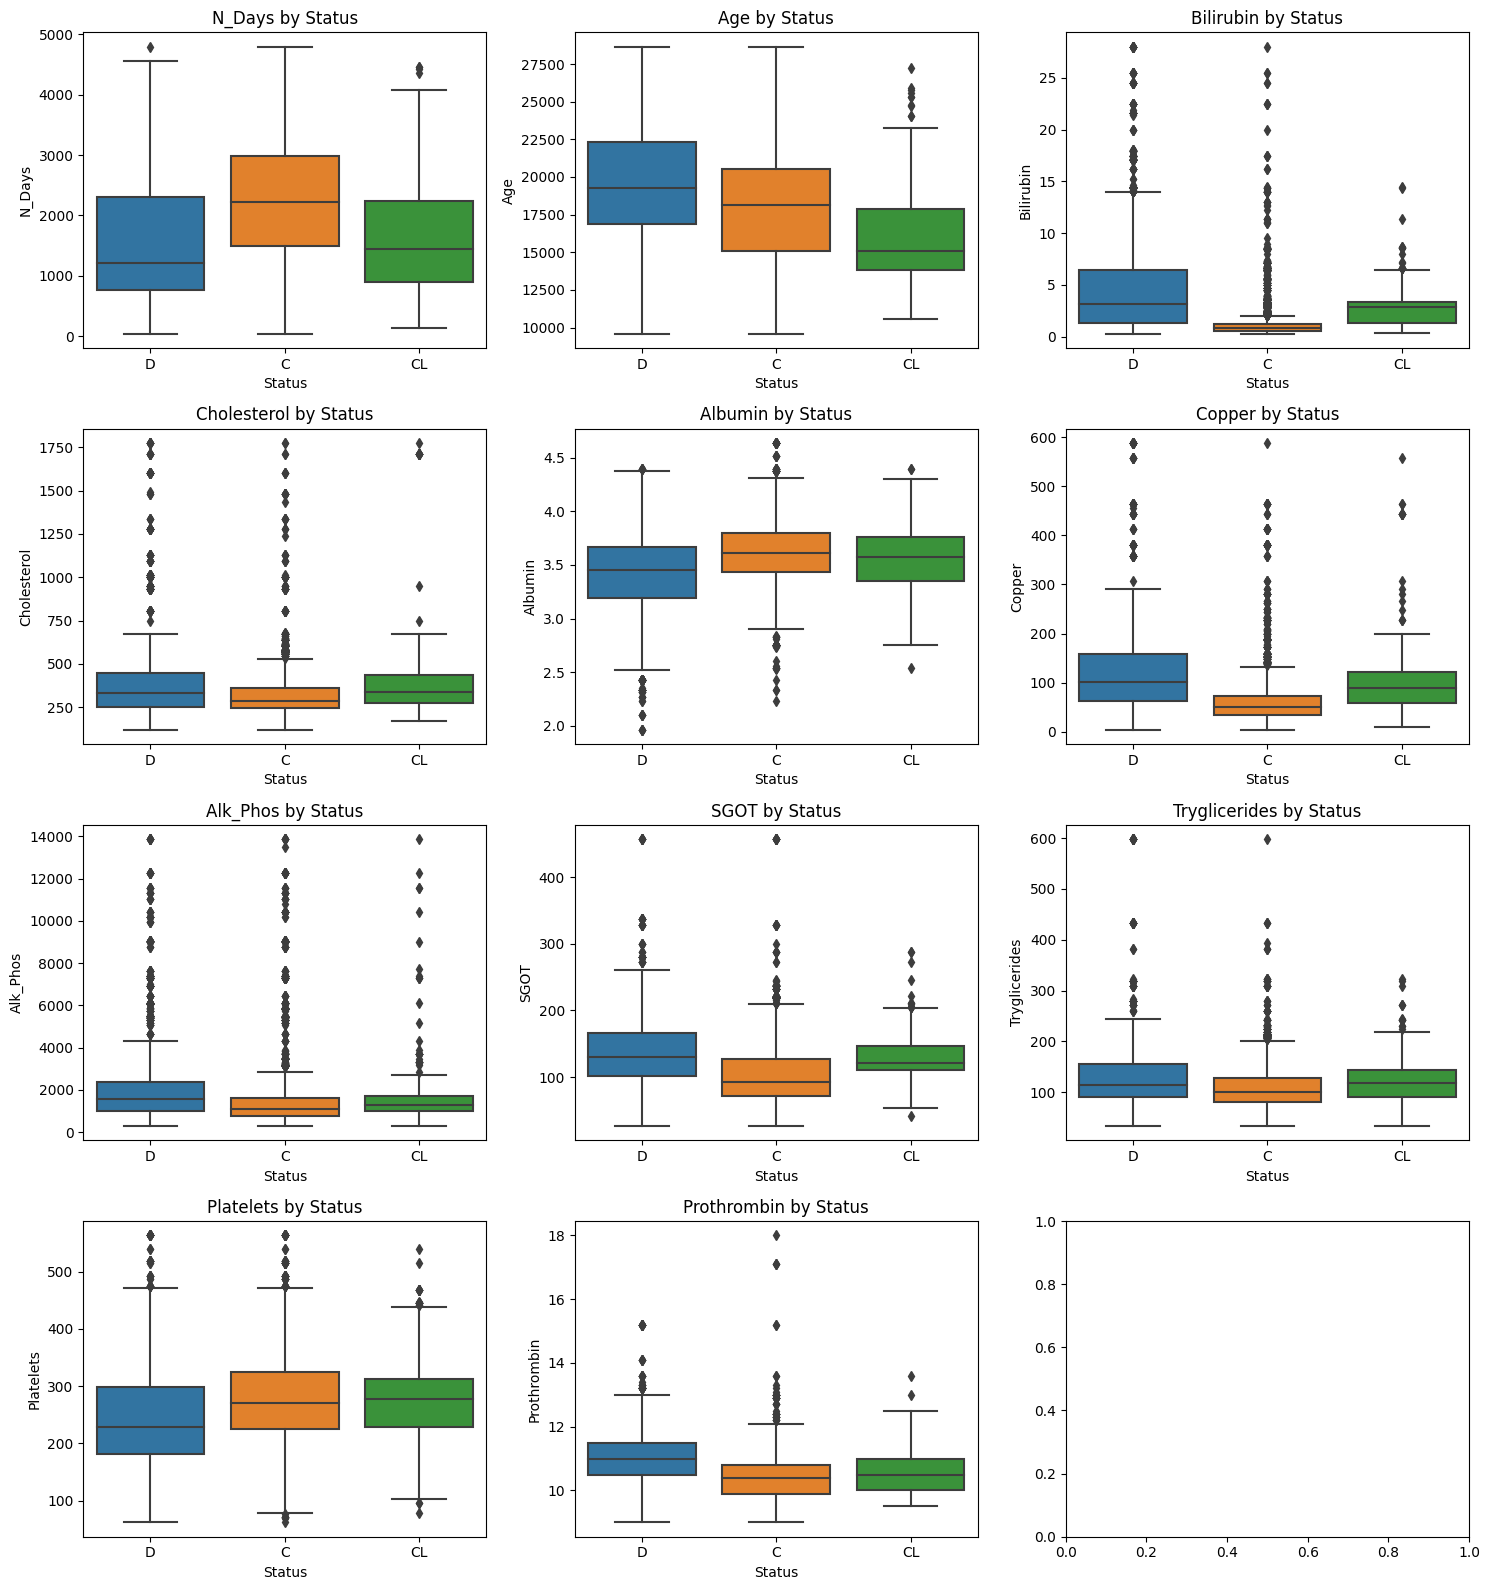

In [4]:
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
num_rows = len(numerical_features) // 3 + (len(numerical_features) % 3 > 0)
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
axes = axes.flatten()
for i, feature in enumerate(numerical_features):
    ax = axes[i]

    sns.boxplot(x='Status', y=feature, data=combined_df, ax=ax)
    ax.set_title(f'{feature} by Status')
    
plt.tight_layout()
plt.show()

# Pairplot of Selected Numerical Features by Cirrhosis Status

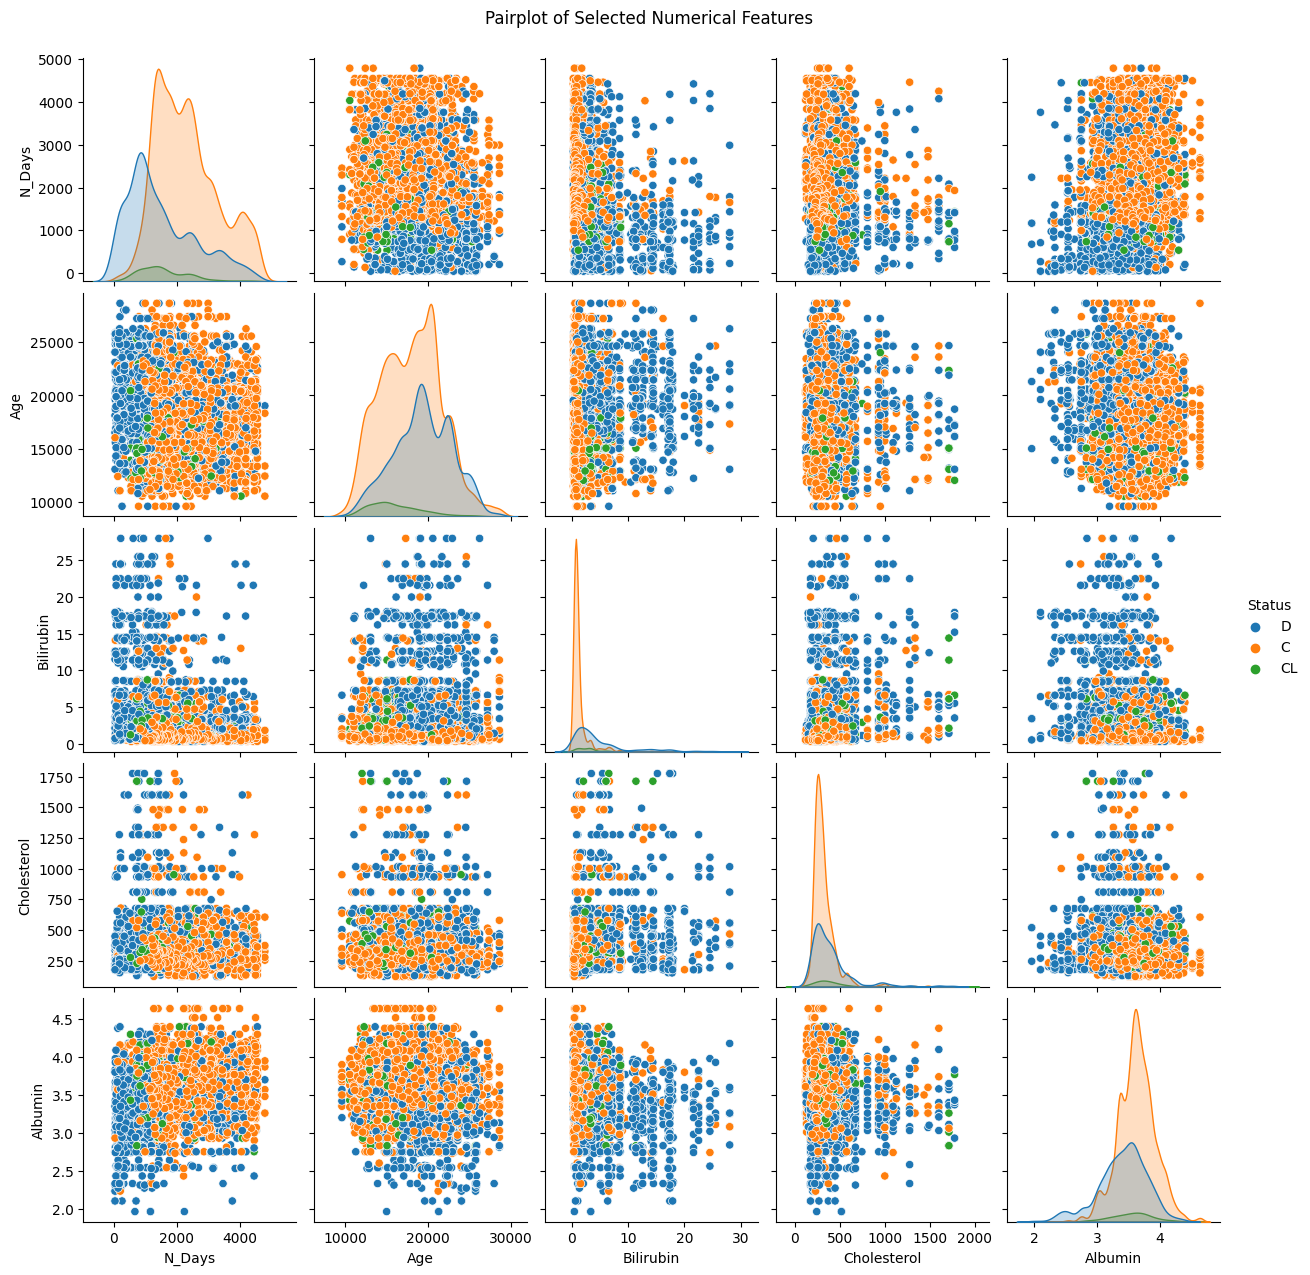

In [5]:
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin']

selected_features = ['Status'] + numerical_features

selected_df = combined_df[selected_features]

sns.pairplot(selected_df, hue='Status', diag_kind='kde')
plt.suptitle('Pairplot of Selected Numerical Features', y=1.02)
plt.show()

# Exploring Feature Correlations in the Encoded Dataset

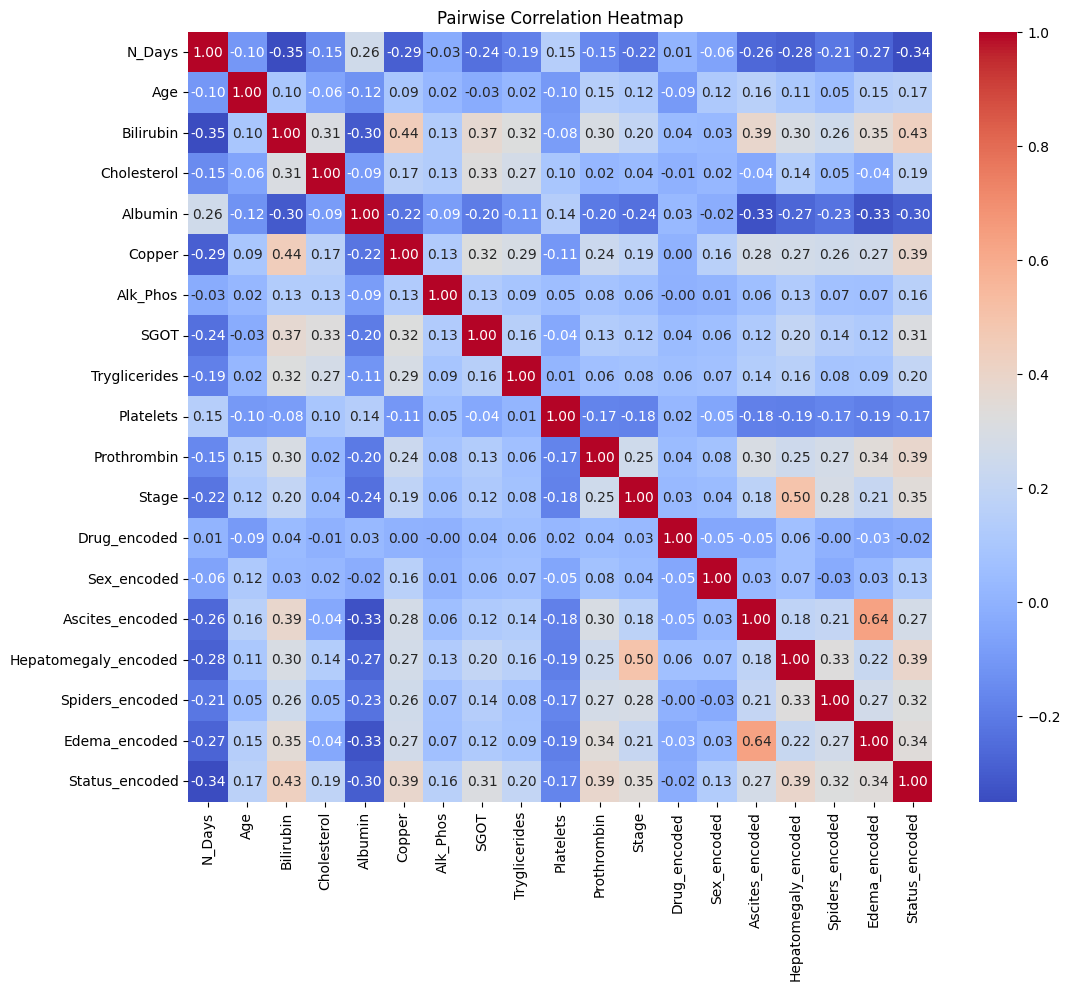

In [6]:
correlation_matrix = encoded_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pairwise Correlation Heatmap')
plt.show()

# Distribution of Cirrhosis Outcomes

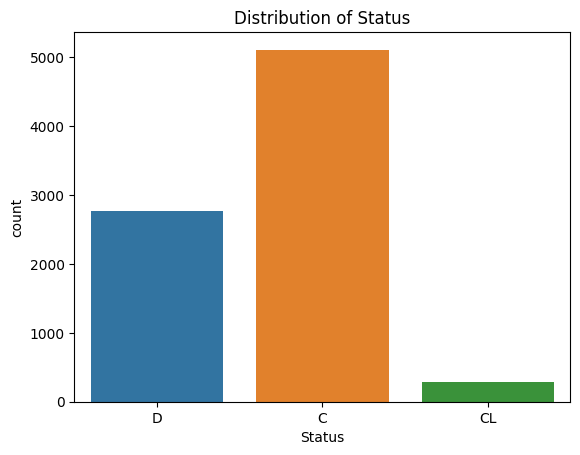

In [7]:
sns.countplot(x='Status', data=combined_df)
plt.title('Distribution of Status')
plt.show()

# Model Building

In [8]:
X = encoded_df.drop('Status_encoded', axis=1)
y = encoded_df['Status_encoded']

train_size = len(train)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_

y_val_pred_proba = best_rf_model.predict_proba(X_val_scaled)
log_loss_val = log_loss(y_val, y_val_pred_proba)

print(f'Log Loss on Validation Set: {log_loss_val}')

Log Loss on Validation Set: 0.460613570040705


In [9]:
# y_test_pred_proba = best_rf_model.predict_proba(test_scaled)
# submission_df = pd.DataFrame({
#     'Status_C': y_test_pred_proba[:, 0],
#     'Status_CL': y_test_pred_proba[:, 1],
#     'Status_D': y_test_pred_proba[:, 2]
# })
# result_df = pd.concat([sub['id'], submission_df], axis=1)
# sub_reset = sub.reset_index(drop=True)
# submission_reset = submission_df.reset_index(drop=True)
# result_df = pd.concat([sub_reset['id'], submission_reset], axis=1)
# result_df.to_csv('submission.csv', index=False)